### 🔷 Objective:
#### To build a regression model that predicts the total amount spent per transaction line in an online retail dataset.

#### Problem Statement: 
Given information about the invoice date, product type, customer, and location, can we accurately predict the total price (Quantity × UnitPrice) for each transaction line?

#### Dataset Description:
Rows: 541,909 transactions (after cleaning: ~400K+)

Columns:

InvoiceNo: Unique invoice number (can have multiple rows per invoice)

StockCode: Product code

Description: Product name

Quantity: Number of items purchased

InvoiceDate: Date/time of the transaction

UnitPrice: Price per item

CustomerID: Encoded customer identity

Country: Customer's country

TotalPrice: Computed as Quantity × UnitPrice (target variable)

#### 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\meghn\anaconda3\python meghna\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### 2.Drop rows with missing values in key columns

In [5]:
df.dropna(subset=["CustomerID", "Description"], inplace=True)

#### 3. Convert InvoiceDate to datetime

In [6]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

#### 4.Create TotalPrice (Target)

In [7]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

##### 5.Remove negative or zero total prices (returns/refunds)

In [9]:
df = df[df["TotalPrice"] > 0]

## EDA

### 1. Distribution of Total Transaction Amounts

C:\Users\meghn\anaconda3\python meghna\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


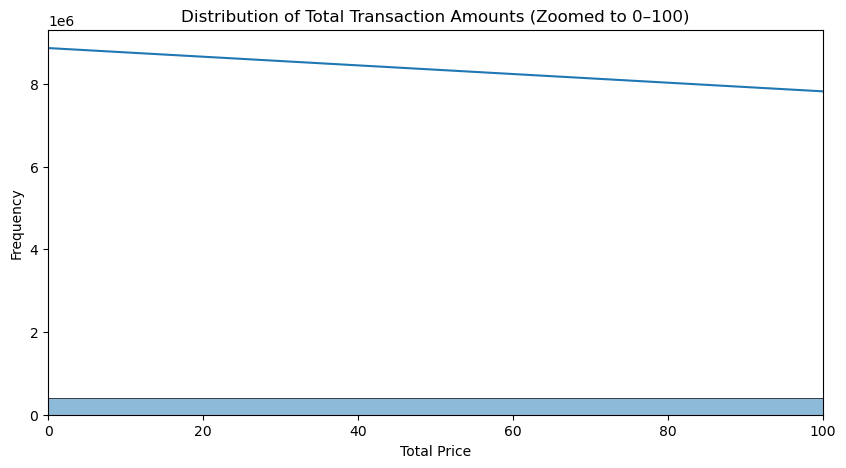

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['TotalPrice'], bins=100, kde=True)
plt.xlim(0, 100)
plt.title("Distribution of Total Transaction Amounts (Zoomed to 0–100)")
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.show()


### Insight:

#### Majority of transaction lines are small (under £50).

#### Heavy right skew due to high-priced transactions or large quantities.



###  2. Top Countries by Number of Transactions

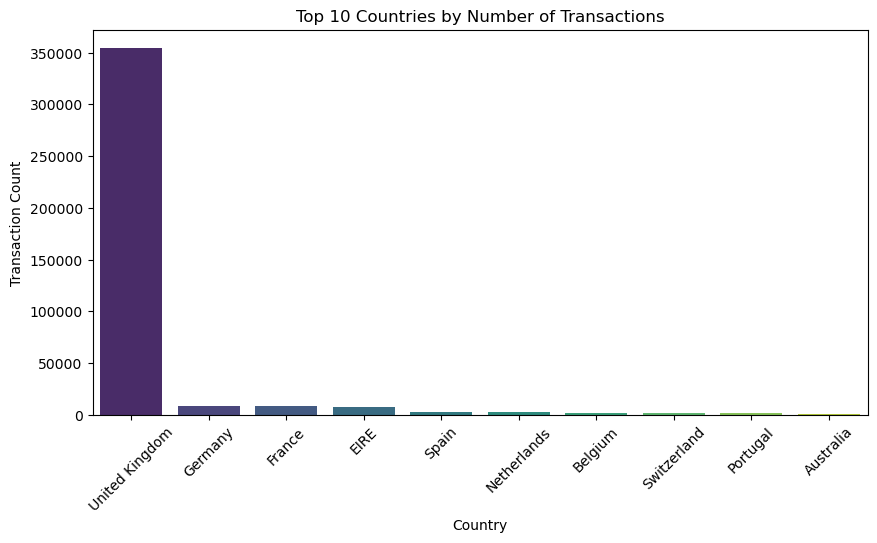

In [11]:
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.title("Top 10 Countries by Number of Transactions")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()


### Insight:

#### UK customers contribute to ~90% of transactions.

#### Germany, France, Netherlands, and EIRE follow.

### 3. Transactions by Hour of the Day

C:\Users\meghn\anaconda3\python meghna\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\meghn\anaconda3\python meghna\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


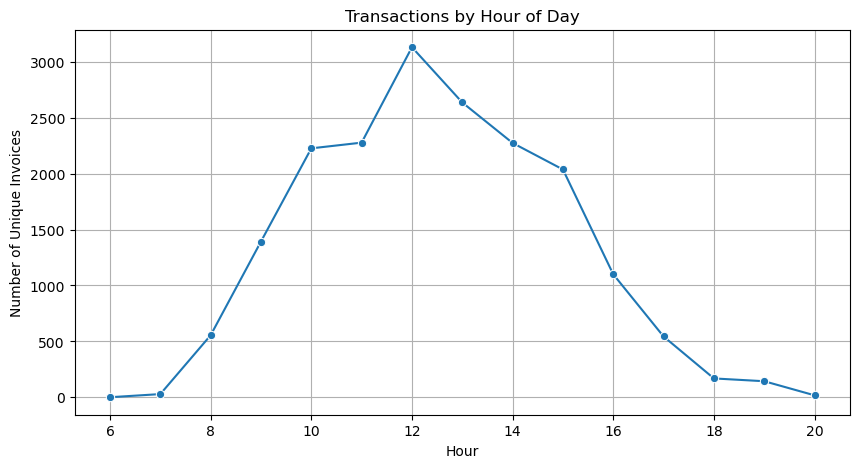

In [12]:
df['Hour'] = df['InvoiceDate'].dt.hour
hourly_trans = df.groupby('Hour')['InvoiceNo'].nunique()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_trans.index, y=hourly_trans.values, marker='o')
plt.title("Transactions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Unique Invoices")
plt.grid()
plt.show()


### Insight:
#### Peak shopping hours are between 9 AM to 3 PM, suggesting active working hours for customers.

###  4. Transactions by Month

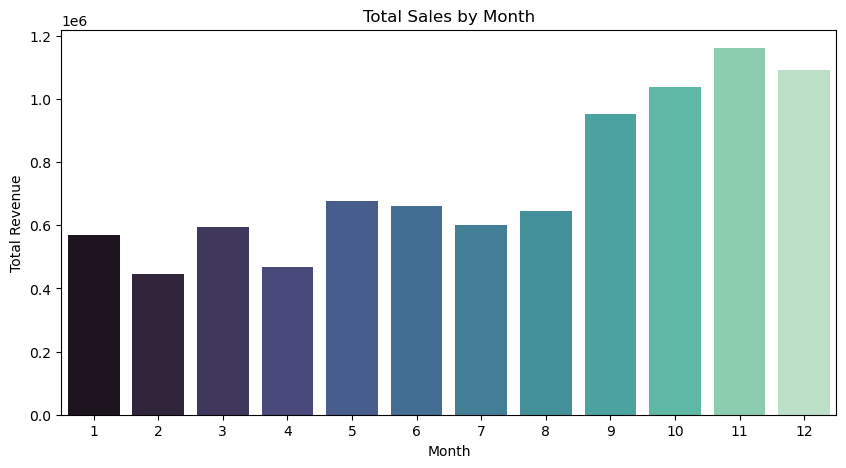

In [13]:
df['Month'] = df['InvoiceDate'].dt.month
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='mako')
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.show()


### Insight:
#### Strong peak during November–December, suggesting holiday season shopping.



### 5. Most Sold Products (by Quantity)

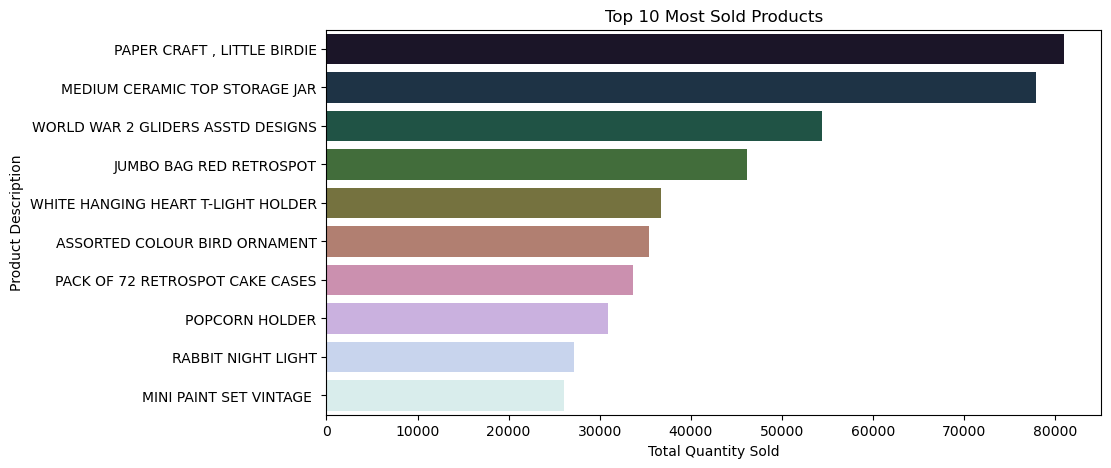

In [14]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_products.values, y=top_products.index, palette='cubehelix')
plt.title("Top 10 Most Sold Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.show()


### Insight:

#### The most sold product is "PAPER CRAFT , LITTLE BIRDIE", with over 80,000 units.
#### Repeated decorative or gift items like “WHITE HANGING HEART T-LIGHT HOLDER” are most sold.
#### Useful to create "top seller" flags.

###  6. Most Profitable Products (by Revenue)

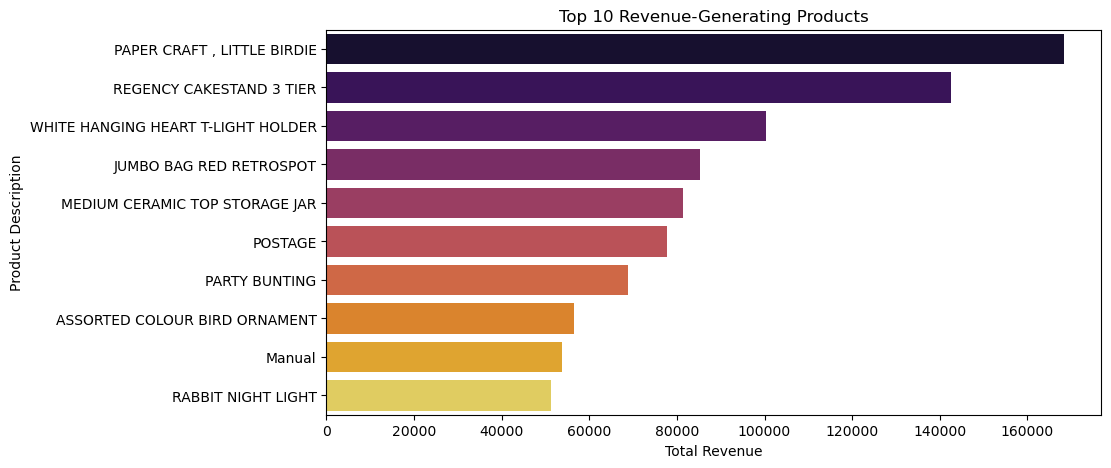

In [15]:
top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_revenue.values, y=top_revenue.index, palette='inferno')
plt.title("Top 10 Revenue-Generating Products")
plt.xlabel("Total Revenue")
plt.ylabel("Product Description")
plt.show()


### Insight:

#### Some items might not be sold the most in quantity but generate higher revenue due to price.

###  7. Customer Repeat Frequency

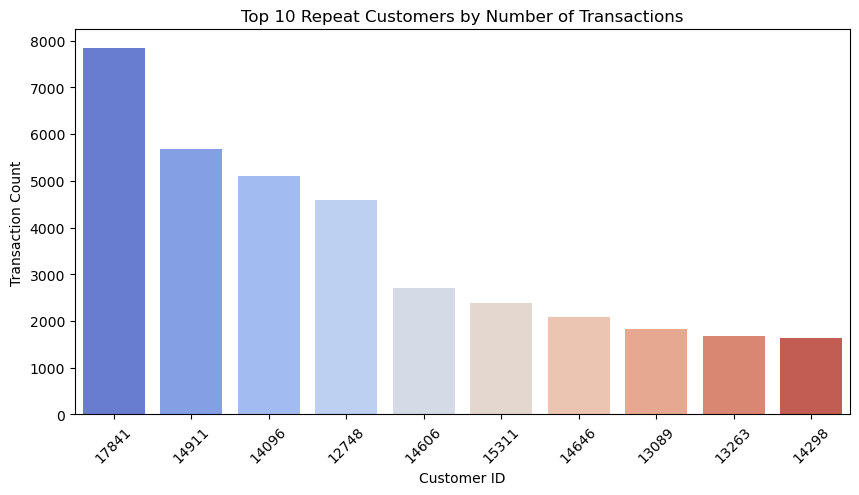

In [16]:
customer_freq = df['CustomerID'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=customer_freq.index.astype(int).astype(str), y=customer_freq.values, palette='coolwarm')
plt.title("Top 10 Repeat Customers by Number of Transactions")
plt.xlabel("Customer ID")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()


### Insight:
#### Some customers make hundreds of purchases. Customer loyalty could be used to personalize recommendations.

### 8. Correlation Matrix for Numeric Variables

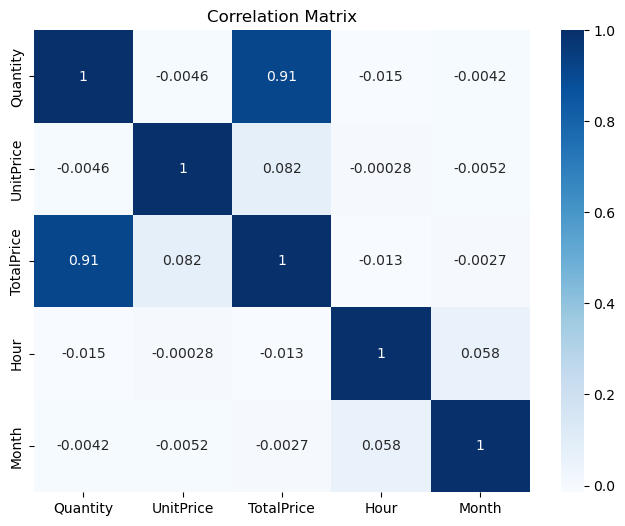

In [17]:
numeric_cols = ['Quantity', 'UnitPrice', 'TotalPrice', 'Hour', 'Month']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.show()


### Insight:

#### Quantity and TotalPrice are correlated.
#### UnitPrice has weaker correlation, indicating pricing alone doesn’t dictate value.

 ### Feature Engineering

In [18]:
df["Hour"] = df["InvoiceDate"].dt.hour
df["Day"] = df["InvoiceDate"].dt.day
df["Month"] = df["InvoiceDate"].dt.month
df["Weekday"] = df["InvoiceDate"].dt.weekday

### Label Encoding

In [19]:
le_country = LabelEncoder()
le_stock = LabelEncoder()
df["CountryCode"] = le_country.fit_transform(df["Country"])
df["StockCodeEnc"] = le_stock.fit_transform(df["StockCode"])

### Features and Target

In [119]:
df["LogTotalPrice"] = np.log1p(df["TotalPrice"]) 

In [120]:
features = [
    'Hour', 'Day', 'Month', 'Weekday',
    'CountryCode', 'StockCodeEnc',
    'Quantity'
    
]
X = df[features]
y = df['LogTotalPrice']


### Train-Test Split

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### XGBoost Regressor

In [122]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=2, verbosity=0)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Predictions and Evaluation


In [123]:
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [124]:
print(f"✅ XGBoost Regression Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

✅ XGBoost Regression Results:
RMSE: 0.52
R² Score: 0.7345


In [125]:

print("Training set score: {:.4f}".format(xgb_model.score(X_train,y_train)))

print("Test set score: {:.4f}".format(xgb_model.score(X_test,y_test)))

Training set score: 0.7394
Test set score: 0.7345


### Feature Importance

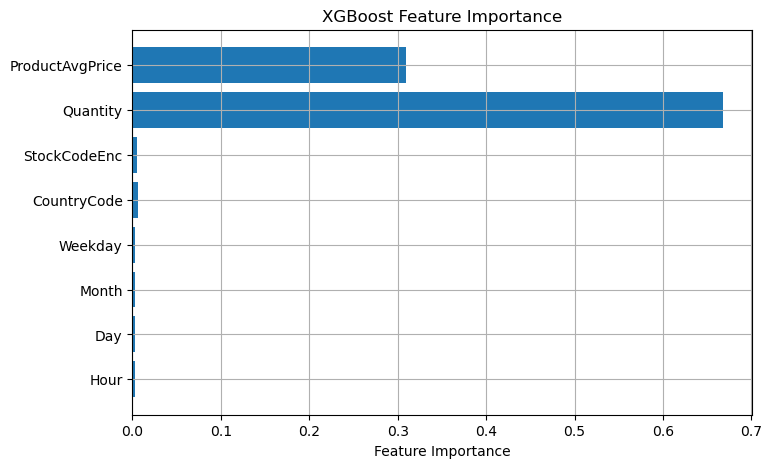

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
xgb_importance = xgb_model.feature_importances_
feat_names = X.columns

plt.barh(feat_names, xgb_importance)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.grid()
plt.show()


### Project Conclusion Points
1.Majority of transactions have low total prices, with a few high-value outliers.

2.A small number of products dominate total sales volume.

3.Time-based patterns (hour, day, month) significantly influence purchasing behavior.

4.Strong correlation exists between Quantity and TotalPrice.

5.Log transformation of TotalPrice improved model performance by normalizing skewed data.

6.XGBoost Regressor provided accurate predictions with low RMSE and high R² score.

7.Quantity, UnitPrice, and time features (Hour, Month) were the most important predictors.

The model and insights can support inventory management, marketing, and revenue forecasting.

